In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import jellyfish
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import vstack

from matchers import metrics, utils, dataset

In [4]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [5]:
# Only need to run this once
# It we split the data into train/test and will persist the data on disk
# dataset.load_split_init(test_size=0.1)

In [6]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, all_candidates_train = train
input_names_test, weighted_relevant_names_test, all_candidates_test = test

all_candidates = np.concatenate((all_candidates_train, all_candidates_test))

### Model

In [7]:
def calc_similarity_to(name, alg='levenshtein'):
    name = utils.remove_padding(name)
    def calc_similarity(row):
        cand_name = utils.remove_padding(row[0])
        similarity = 0
        if alg == 'levenshtein':
            dist = jellyfish.levenshtein_distance(name, cand_name)
            similarity = 1 - (dist / max(len(name), len(cand_name)))
        elif alg == 'jaro_winkler':
            similarity = jellyfish.jaro_winkler_similarity(name, cand_name)
        return similarity
    return calc_similarity

#### Similarity Function

In [8]:
def get_similars(name, k=10, alg='levenshtein', demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    scores = np.apply_along_axis(calc_similarity_to(name, alg), 1, all_candidates[:,None])
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [9]:
# get_similars('schumacher', 10, 'jaro_winkler', True)
get_similars('bostelman', 10, 'levenshtein', True)

[('bostelman', 1.0),
 ('bostelmann', 0.9),
 ('bostleman', 0.7777777777777778),
 ('vosselman', 0.7777777777777778),
 ('osterman', 0.7777777777777778),
 ('bokelman', 0.7777777777777778),
 ('bockelman', 0.7777777777777778),
 ('bushelman', 0.7777777777777778),
 ('fosselmann', 0.7),
 ('klosterman', 0.7)]

## Generate levenshtein scores for all test names

In [10]:
k = 100 # Number of candidates to consider
lev_name_candidates = list(map(lambda x: get_similars(x, k=k, alg='levenshtein'), tqdm(input_names_test)))

100%|██████████| 2444/2444 [03:43<00:00, 10.96it/s]


In [11]:
len(lev_name_candidates)

2444

#### Ugh - how can I specify [[[str,float64]]] without taking apart and re-assembling the array?

In [12]:
names = np.array(list(list(cell[0] for cell in row) for row in lev_name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in lev_name_candidates), dtype='f8')
lev_candidates = np.dstack((names, scores))

### Evaluation

In [13]:
relevant_names_test = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_test]
candidate_names_test = [[name for name, _ in name_similarities] for name_similarities in lev_name_candidates]

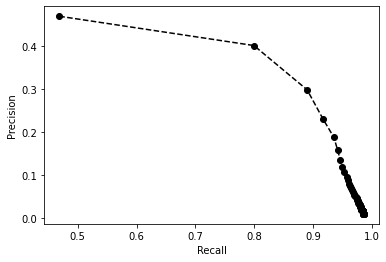

In [14]:
metrics.precision_recall_curve(relevant_names_test, candidate_names_test, k)

#### Precision@0.8

In [61]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, lev_candidates, 0.833)

0.6243342146658792

#### Recall@0.8

In [60]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, lev_candidates, 0.833)

0.811057863747893

#### Precision-Recall Curve

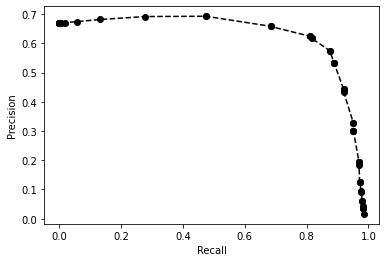

In [17]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, lev_candidates, min_threshold)

In [50]:
metrics.get_auc(weighted_relevant_names_test, lev_candidates, step=.01)

0.6354260895680246

## Generate jaro-winkler scores for all test names

In [18]:
k = 100 # Number of candidates to consider
jw_name_candidates = list(map(lambda x: get_similars(x, k=k, alg='jaro_winkler'), tqdm(input_names_test)))

100%|██████████| 2444/2444 [03:27<00:00, 11.76it/s]


In [19]:
len(jw_name_candidates)

2444

In [20]:
names = np.array(list(list(cell[0] for cell in row) for row in jw_name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in jw_name_candidates), dtype='f8')
jw_candidates = np.dstack((names, scores))

### Evaluation

In [21]:
candidate_names_test = [[name for name, _ in name_similarities] for name_similarities in jw_name_candidates]

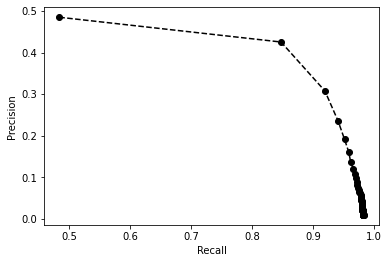

In [22]:
metrics.precision_recall_curve(relevant_names_test, candidate_names_test, k)

#### Precision@0.92

In [23]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, jw_candidates, 0.88)

0.30025209139634457

#### Recall@0.92

In [24]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, jw_candidates, 0.88)

0.9547201989339293

#### Precision-Recall Curve

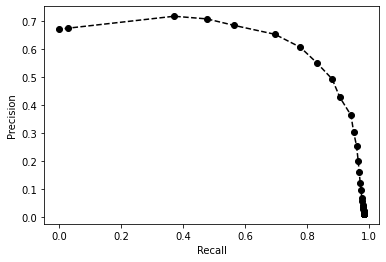

In [25]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, jw_candidates, min_threshold)

## Test

In [26]:
input_names_test[251]

'<bostelman>'

In [27]:
weighted_relevant_names_test[251]

[('<bostelmann>', 0.6784565916398714, 211),
 ('<bostleman>', 0.3215434083601286, 100)]

In [28]:
lev_candidates[251,:5]

array([['<bostelman>', 1.0],
       ['<bostelmann>', 0.9],
       ['<bostleman>', 0.7777777777777778],
       ['<vosselman>', 0.7777777777777778],
       ['<osterman>', 0.7777777777777778]], dtype=object)

In [29]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], lev_candidates[251], 0.85)

0.6784565916398714

In [30]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], lev_candidates[251], 0.75)

1.0